# Exercice 5
Go to Bloomberg or Yahoo Finance to download the daily commodity price of your
choice from January 1, 2020 until September 30, 2025. Compute its continous daily, monthly and
quarterly return. Specify a markov switching autoregression model on these 3 time series from the
beginning of your sample till December 31, 2022. Next, do some forecasts over the next 3 quarters, 9
months and the subsequent days (for this daily prediction, please predict 20-step ahead forecasts and
next re-estimaste your model by including the true realizations - recursive window - and predict again
20-step ahead forecasts, do it till the end of the sample). You may use statmodels to do it. Be careful,
you have to figure out which SARIMA-GARCH model you should apply first on the time series before
adding a Markov Switching process. Describe your models and comment your results in a Jupyter
Notebook

### From ARMA-GARCH to Markov Switching models

Let $y_t$ denote a return series. A standard single-regime ARMA-GARCH model is
written as

$$
y_t = \mu + \sum_{i=1}^{p} \phi_i y_{t-i}
      + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j}
      + \varepsilon_t
$$

with innovations

$$
\varepsilon_t = \sqrt{h_t} z_t, \quad z_t \sim iid(0,1)
$$

and conditional variance

$$
h_t = \omega + \alpha \varepsilon_{t-1}^2 + \beta h_{t-1}
$$

In this framework, the conditional mean and conditional variance evolve over
time, but all parameters are constant. The model therefore describes a single
data-generating regime.

A Markov Switching model generalizes this framework by allowing some or all
parameters to depend on an unobserved regime variable $S_t$. The regime variable
takes values in {1,...,K} and follows a first-order Markov chain with transition
probabilities

$$
P(S_t = j | S_{t-1} = i) = p_{ij}
$$

Conditional on $S_t$, the return process follows regime-specific dynamics. For
example, a Markov Switching AR(1) model with regime-dependent variance can be
written as

$$
y_t = \mu_{S_t} + \phi_{S_t} y_{t-1} + \varepsilon_t
$$

with

$$
\varepsilon_t \sim N(0,\sigma_{S_t}^2)
$$

In this specification, the Markov switching mechanism acts directly on the
parameters of the conditional mean and variance. Changes in S_t generate
discrete shifts in the level, persistence, and volatility of returns.

In practice, an ARMA-GARCH model is first estimated to capture linear
dependence and volatility clustering. The Markov Switching structure is then
introduced to account for regime-dependent dynamics that cannot be explained
by a single-regime model. Forecasts combine regime-specific predictions with
the estimated transition probabilities.


<u>Visual Analysis</u>

In this first step, we compute and plot the continuous returns of the commodity price at three different frequencies: daily, monthly, and quarterly. For each series, we visualize the raw returns together with rolling estimates of the mean and volatility. This preliminary graphical analysis serves several purposes. First, it allows us to visually assess whether returns are centered around zero and whether their variance appears stable or time-varying. Second, it helps detect potential volatility clustering, regime shifts, or structural breaks, which are key motivations for using Markov Switching models. Finally, comparing the same asset across different sampling frequencies allows us to understand how temporal aggregation affects the dynamics and the information content of the returns.

[*********************100%***********************]  1 of 1 completed


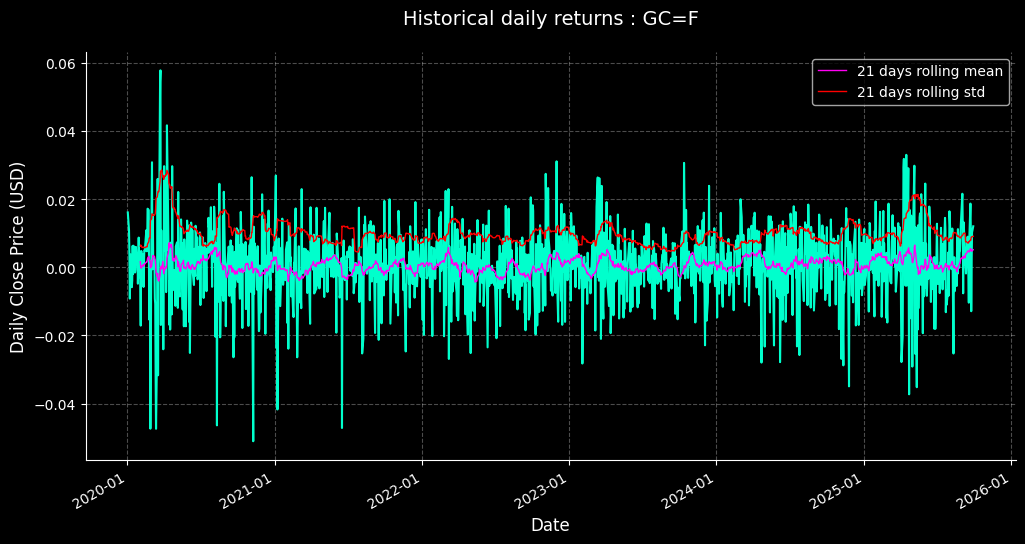

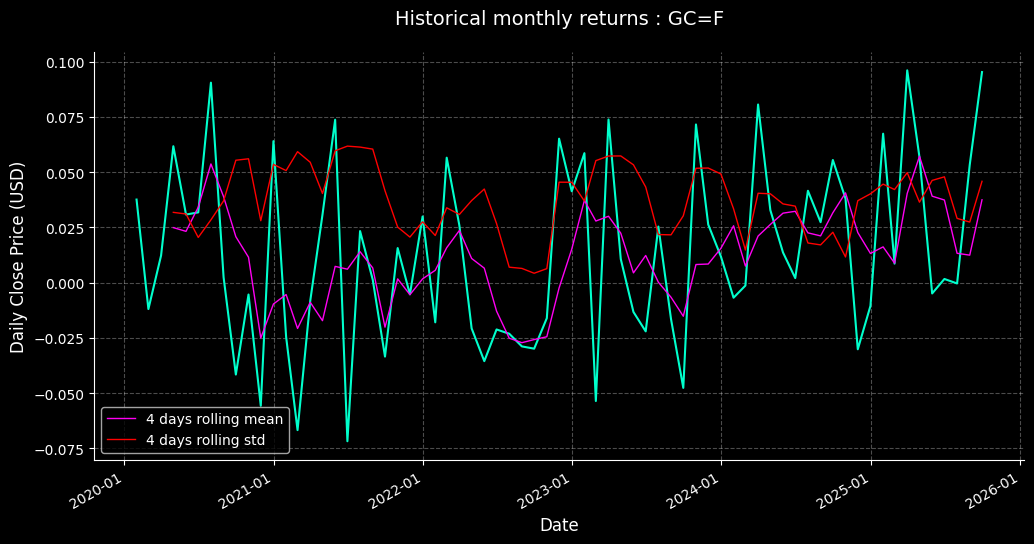

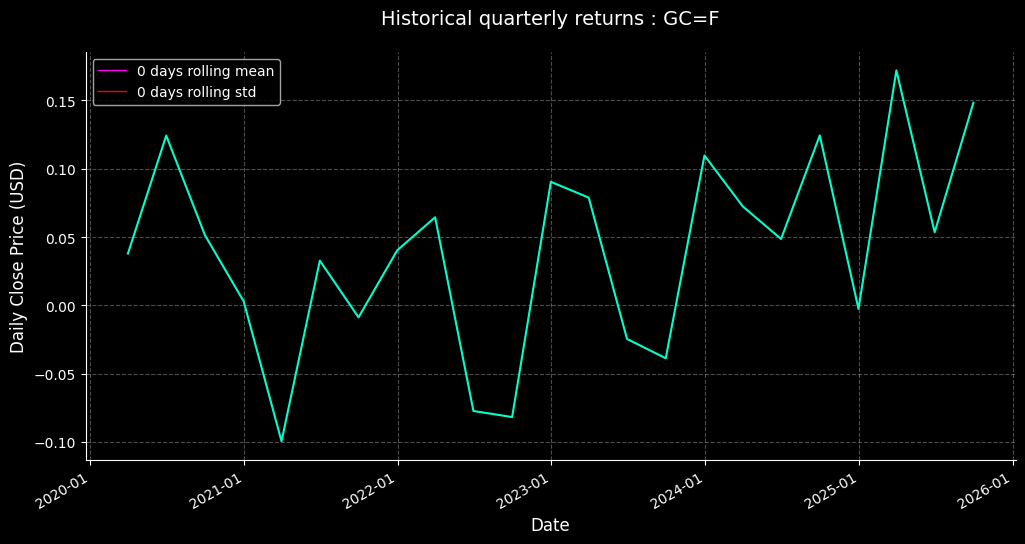

In [10]:
import importlib
import utils.utils as utils
import pandas as pd
import numpy as np
importlib.reload(utils)
TICKER = "GC=F" 
START= "2020-01-01"
END_TRAINING = "2022-12-31"
END = "2025-09-30"
prices_df = utils.retrieve_data_from_yf(TICKER, START, END).dropna()
daily_ret = np.log(prices_df).diff().dropna()
monthly_ret = daily_ret.resample("M").sum()
quarterly_ret = daily_ret.resample("Q").sum()
utils.plot_prices(daily_ret, TICKER, title = f"Historical daily returns : {TICKER}")
utils.plot_prices(monthly_ret, TICKER, title = f"Historical monthly returns : {TICKER}", window_size = 4)
utils.plot_prices(quarterly_ret, TICKER, title = f"Historical quarterly returns : {TICKER}", window_size = 0)
daily_ret.index = [k.strftime("%Y-%m-%d") for k in daily_ret.index]
monthly_ret.index = [k.strftime("%Y-%m-%d") for k in monthly_ret.index]
quarterly_ret.index = [k.strftime("%Y-%m-%d") for k in quarterly_ret.index]

<u> Interpretation</u>
- <b> Daily returns </b>
The daily returns display strong short-term fluctuations around zero, with clear episodes of heightened volatility followed by calmer periods. This volatility clustering is especially visible during stress periods, where large positive and negative returns tend to occur close in time. The rolling standard deviation varies substantially over the sample, indicating that volatility is far from constant. This behavior is consistent with financial time series stylized facts and strongly suggests the presence of multiple latent regimes, such as low-volatility and high-volatility states. From a modeling perspective, the daily frequency appears particularly well-suited for a Markov Switching framework, as regime changes are frequent and sufficiently informative.
- <b> Monthly returns </b>
At the monthly frequency, returns are smoother but still exhibit noticeable variability over time. Extreme observations are less frequent than in the daily series, yet periods of higher and lower volatility remain identifiable. The rolling mean appears more persistent, occasionally deviating from zero for extended periods, which may reflect medium-term market trends or macroeconomic conditions. However, regime changes are less abrupt than in the daily data, suggesting that some short-lived volatility regimes are averaged out through temporal aggregation. Markov Switching models remain relevant here, but regime identification may be less sharp and transition probabilities may be more persistent.

- <b> Quarterly returns</b>
Quarterly returns are much noisier in terms of inference, despite appearing visually smoother. The number of observations is substantially smaller, which limits statistical power. Large swings in returns still occur, but they are isolated and often driven by the accumulation of shocks over long horizons. The rolling volatility becomes harder to interpret meaningfully, as each observation summarizes a long period of market activity. This raises an important issue: while regime switching may still exist at the quarterly level, identifying distinct regimes becomes statistically challenging due to sample size limitations and excessive aggregation. As a result, any Markov Switching estimation on quarterly data must be interpreted with caution.

<u>STL DECOMPOSITION</u>

To further investigate the structure of the series, we apply a Seasonal-Trend decomposition using Loess (STL). This approach allows us to decompose each time series into a trend component, a seasonal component, and a residual component. Although STL is mainly designed for macroeconomic or low-frequency data, applying it to financial series can still provide useful insights regarding long-term trends, potential calendar effects, and the nature of residual fluctuations.

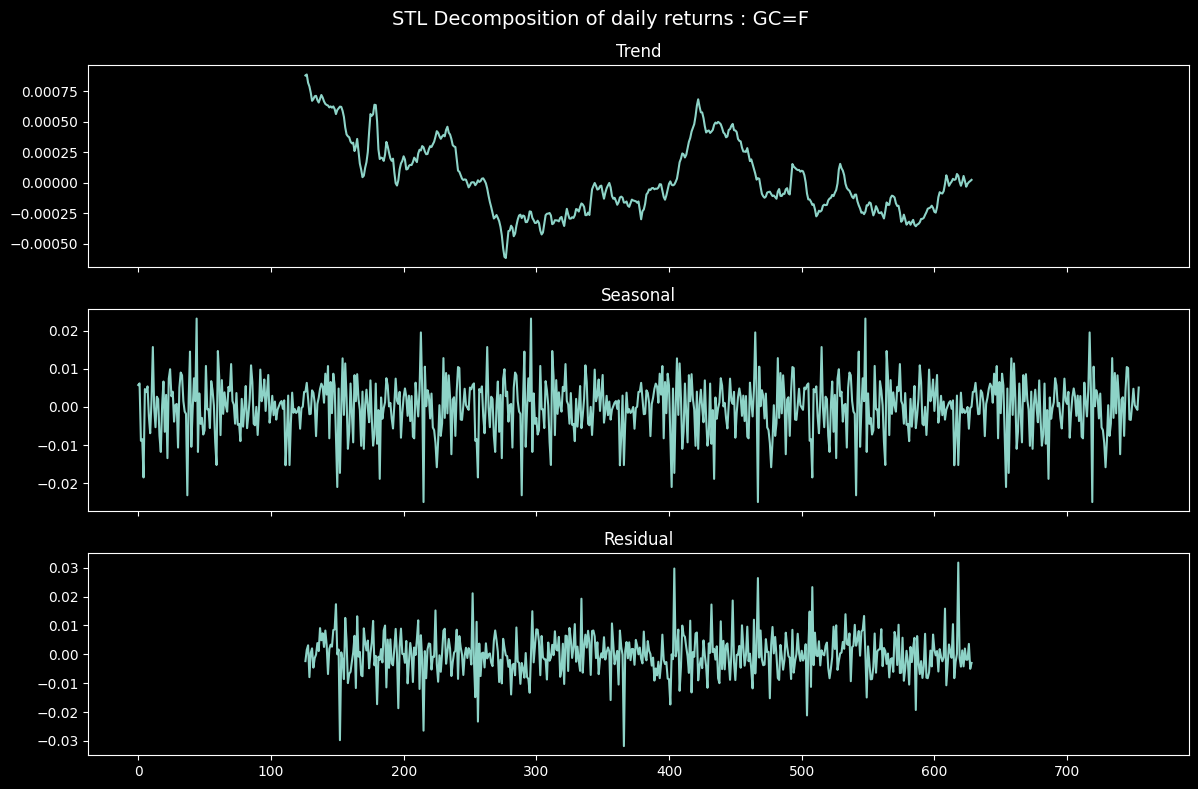

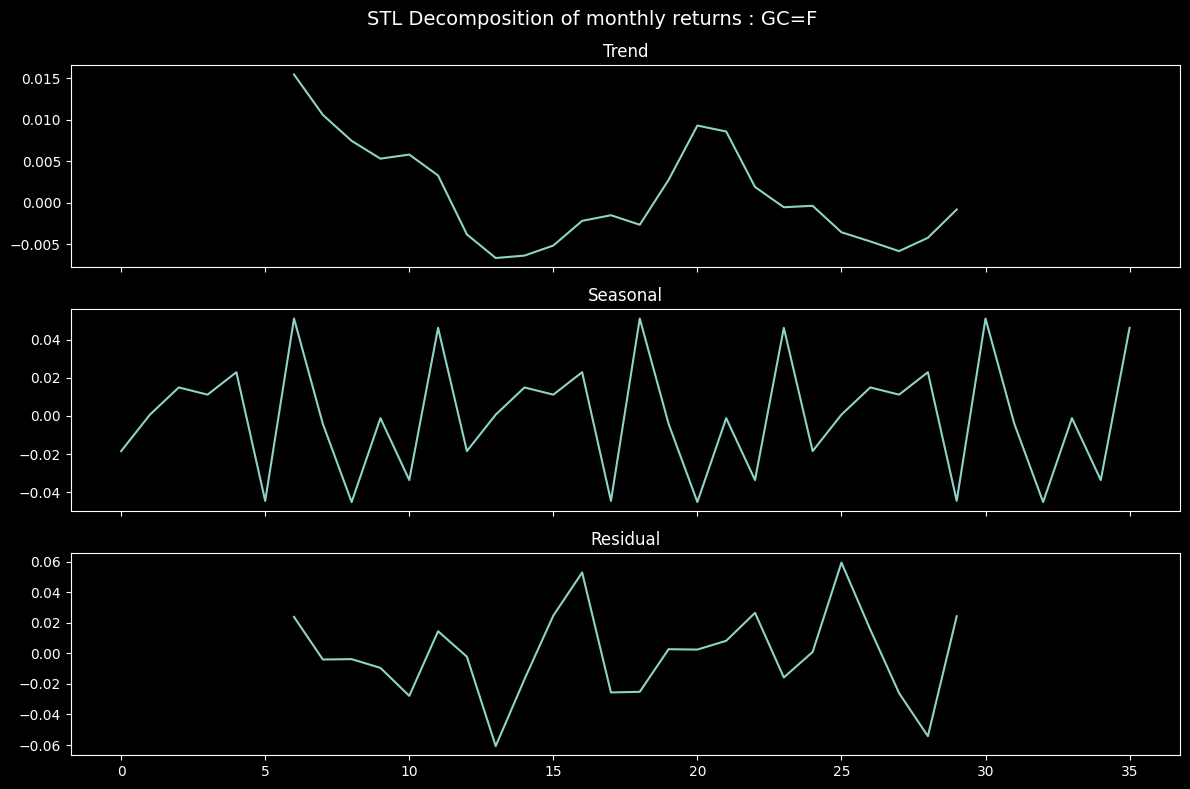

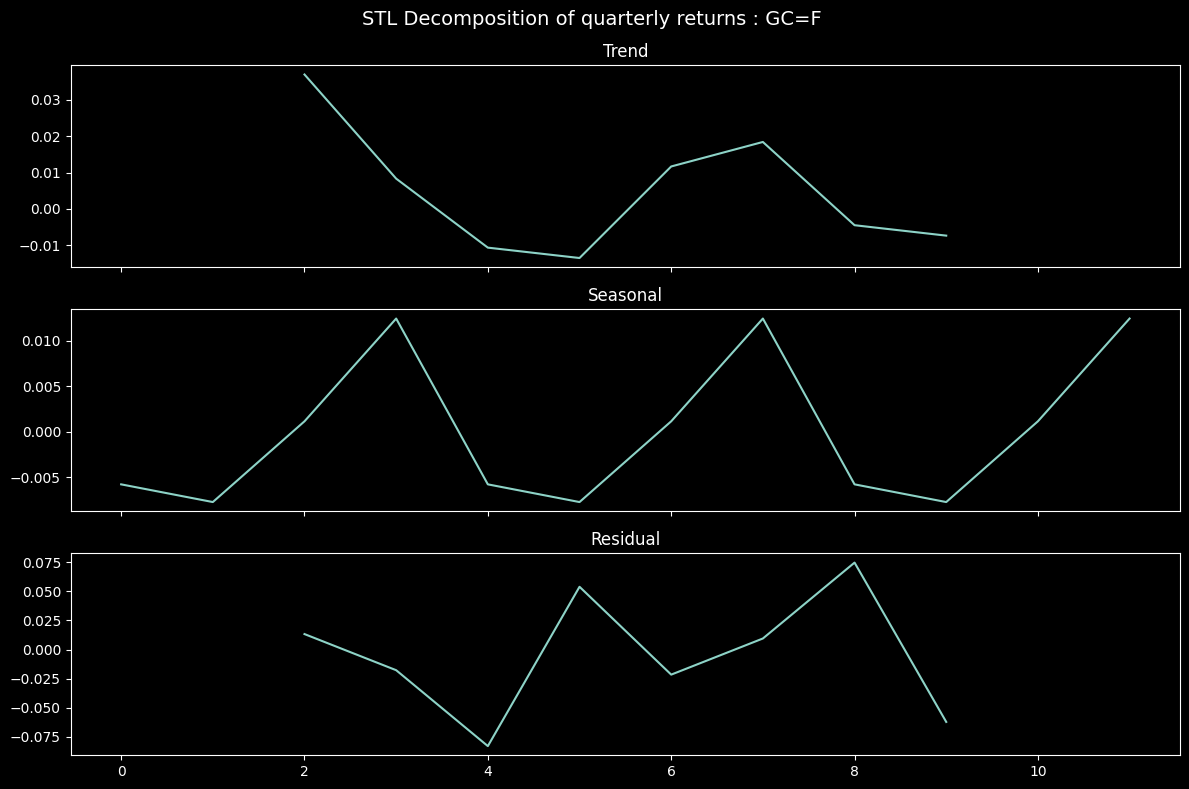

In [11]:
importlib.reload(utils)
utils.get_stl_decomposition(daily_ret.loc[:END_TRAINING], TICKER, "daily returns")
utils.get_stl_decomposition(monthly_ret.loc[:END_TRAINING], TICKER, "monthly returns", period = 12)
utils.get_stl_decomposition(quarterly_ret.loc[:END_TRAINING], TICKER, "quarterly returns", period = 4)

<u> Interpretation </u>
- <b> Daily returns </b>
The STL decomposition of daily returns shows a very weak and noisy seasonal component, while most of the variation is absorbed by the residual component. The trend component evolves slowly and captures long-run shifts rather than systematic dynamics. This confirms that daily returns exhibit little deterministic structure and are mainly driven by stochastic volatility and regime changes.
A non-seasonal ARMA–GARCH model, possibly augmented with a Markov Switching mechanism on volatility or mean, is appropriate. No seasonal component is required.
- <b> Monthly returns </b>
At the monthly frequency, the seasonal component appears more structured but remains economically small relative to the residual variance. The trend component displays medium-term movements, suggesting some persistence but no strong deterministic pattern. Aggregation smooths high-frequency noise without revealing strong seasonality. A low-order ARMA–GARCH model without seasonal terms is sufficient. Markov Switching can be applied to capture medium-term regime changes, but with fewer and more persistent regimes than in daily data.
- <b> Quarterly returns </b>
For quarterly returns, the seasonal component is mechanically imposed by the STL procedure and should not be interpreted as genuine seasonality. The trend dominates due to strong aggregation, while residuals are volatile and sparse because of the small sample size. Seasonality at this frequency is largely an artifact of the decomposition and not economically meaningful. A very parsimonious AR(1) or AR(0)–GARCH, possibly with two-regime Markov Switching, should be used. Any regime-switching result must be interpreted cautiously due to limited observations


<u> ADF tests </u>

In [12]:
importlib.reload(utils)
list_df = [daily_ret.loc[:END_TRAINING], monthly_ret.loc[:END_TRAINING], quarterly_ret.loc[:END_TRAINING]]
names = ["Daily returns", " Monthly returns", "Quarterly returns"]
utils.run_adf_kss_test(list_df, names, TICKER)

                         Augmented Dickey Fuller Results                          
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃              Name ┃ ADF Stat ┃ P-Value ┃ KSS P-Value ┃ Lags Used ┃ Sample size ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│     Daily returns │ -12.9470 │ 0.0000  │   0.1000    │     6     │     748     │
│   Monthly returns │ -5.4982  │ 0.0000  │   0.1000    │     0     │     35      │
│ Quarterly returns │ -3.2542  │ 0.0171  │   0.1000    │     1     │     10      │
└───────────────────┴──────────┴─────────┴─────────────┴───────────┴─────────────┘

<u> Interpretation </u>
- <b> Daily returns </b>
The ADF test strongly rejects the null hypothesis of a unit root, while the KPSS test fails to reject stationarity. This provides consistent evidence that daily returns are stationary. This is in line with standard financial theory, where returns fluctuate around a constant mean with time-varying volatility rather than exhibiting persistent trends. As a result, no differencing is required, and the series can be directly modeled using ARMA–GARCH structures, potentially augmented with Markov Switching to capture regime-dependent volatility dynamics.
- <b> Monthly returns </b>
Monthly returns also reject the unit root hypothesis according to the ADF test, while the KPSS test remains close to but below conventional rejection thresholds. This suggests stationarity, though with slightly weaker statistical power than at the daily frequency due to the smaller sample size. The series can therefore be modeled in levels using low-order ARMA–GARCH models. Markov Switching remains relevant but is expected to identify fewer and more persistent regimes than in daily data.
- <b> Quarterly returns </b>
For quarterly returns, the ADF test fails to reject the presence of a unit root, while the KPSS test does not strongly reject stationarity. This mixed evidence is largely driven by the very small sample size, which severely reduces test power. Economically, quarterly returns are typically stationary, but statistical inference is fragile at this frequency. A very parsimonious specification, such as AR(0) or AR(1)–GARCH with at most two Markov regimes, should be used, and any regime-switching result must be interpreted with caution.

<u> ACF/PACF analysis </u>

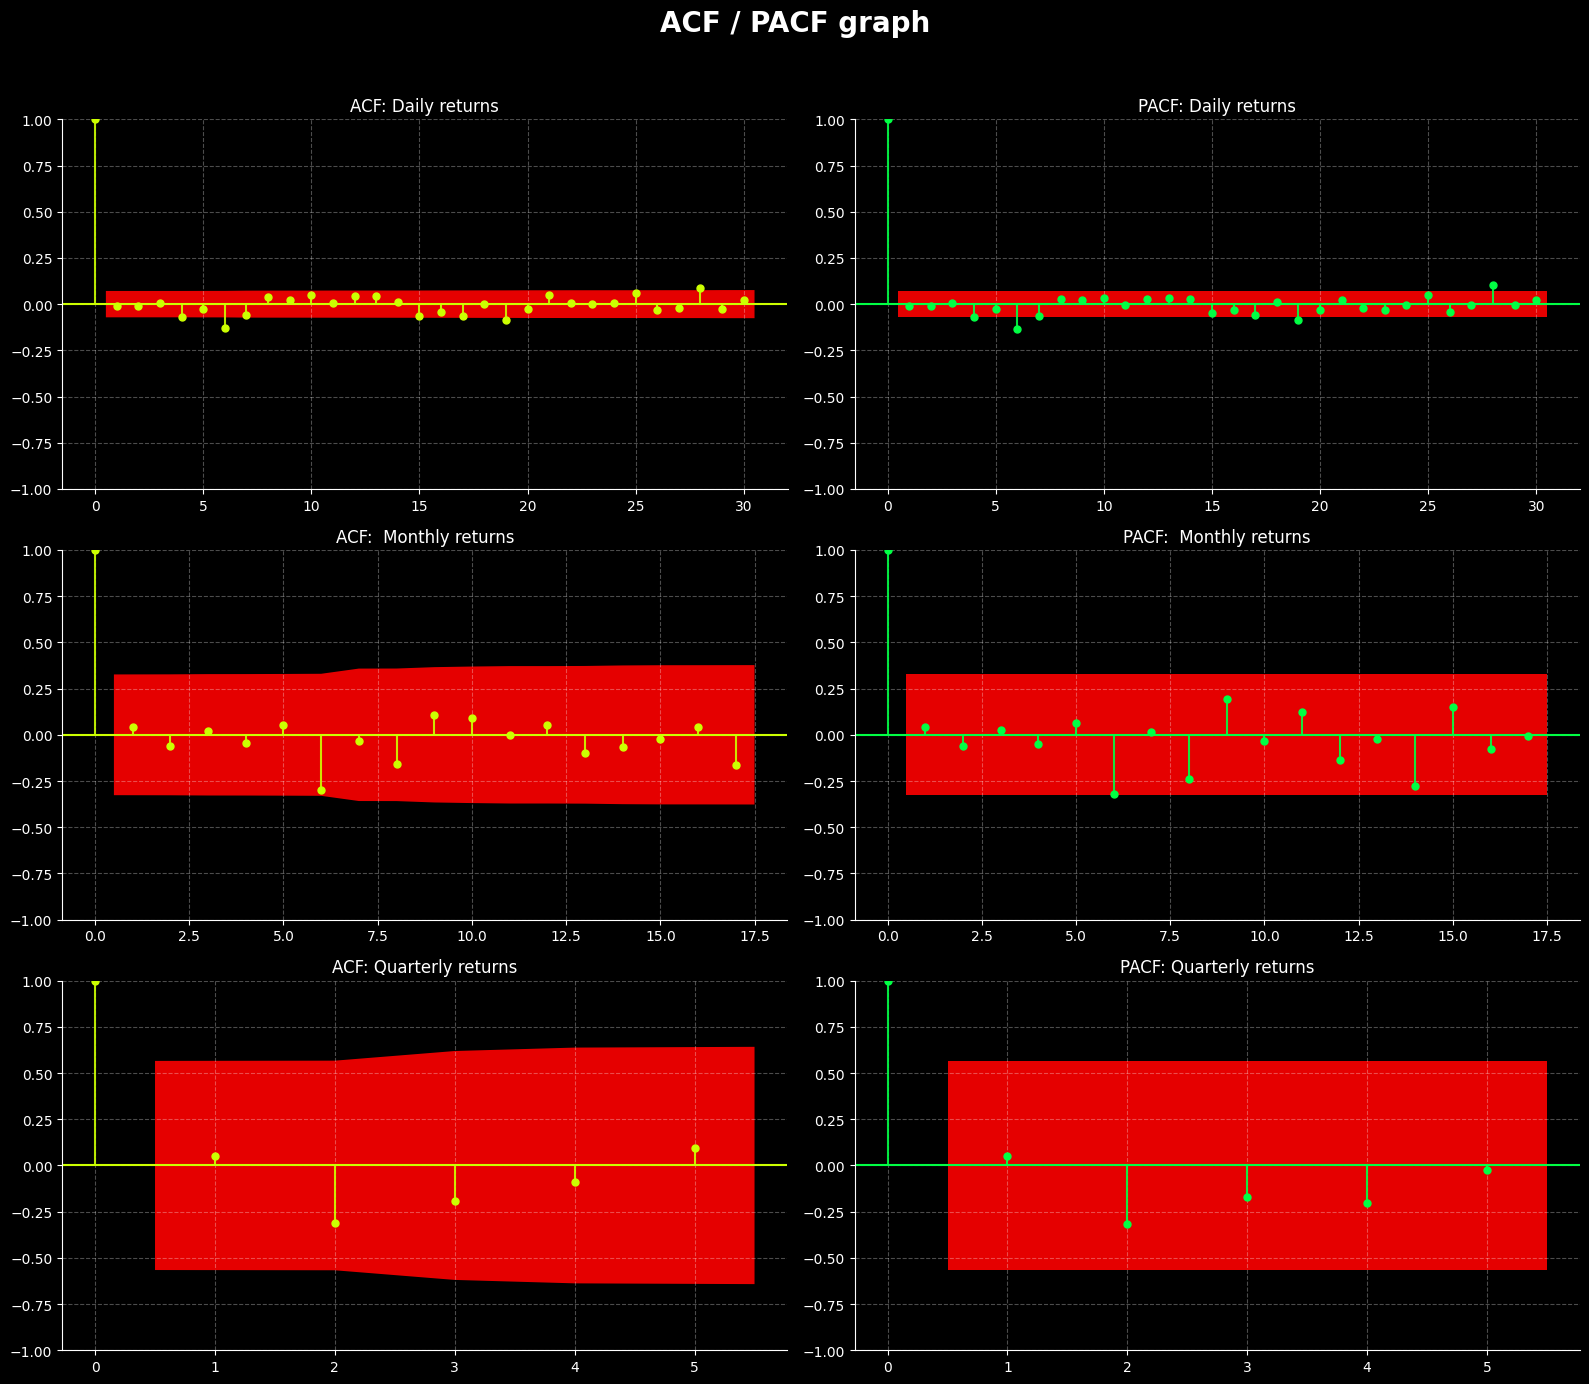

In [13]:
importlib.reload(utils)
utils.plot_acf_pacf(list_df, names, TICKER)

<u> Interpretation </u>
- <b> Daily returns </b>
The ACF and PACF of daily returns show no significant autocorrelation at any lag, with all spikes lying well within the confidence bands. This indicates that daily returns behave approximately as white noise in the mean, with no linear dependence to exploit. Consequently, an ARMA(0,0) specification for the conditional mean is appropriate, and all remaining dynamics should be captured through the conditional variance. This strongly supports the use of a GARCH-type model, potentially combined with Markov Switching in volatility, rather than introducing autoregressive terms in the mean.

- <b> Monthly returns </b>
For monthly returns, the ACF and PACF display small and isolated spikes, but none exhibit a clear decay pattern or sharp cutoff. This suggests at most very weak short-run dependence, likely due to sampling variability rather than genuine predictability. A very low-order ARMA model, such as ARMA(1,0), may be considered, but an ARMA(0,0) specification remains defensible. Markov Switching can be applied to capture regime-dependent behavior without relying heavily on mean dynamics.<

- <b> Quarterly returns </b>
At the quarterly frequency, the ACF and PACF are noisy and unstable, reflecting the extremely small sample size. No robust autocorrelation structure can be identified, and any apparent spikes should not be over-interpreted. A parsimonious AR(0) or AR(1) specification is recommended, primarily for numerical stability rather than forecasting power. If used, Markov Switching should be restricted to two regimes at most, with strong caution in interpretation.<b>Choice</b>

<u> Sanity Checks </u>

In [14]:
_ = utils.interpret_ljungbox(daily_ret.loc[:END_TRAINING], title = "Daily Returns")
_ = utils.interpret_ljungbox(monthly_ret.loc[:END_TRAINING], title = "Monthly Returns")
_ = utils.interpret_ljungbox(quarterly_ret.loc[:END_TRAINING], title = "Quarterly Returns", lags=np.linspace(0,5,5))


=== Ljung–Box Residual Autocorrelation Test Daily Returns===

No autocorrelation up to lag 0 (p = nan)
No autocorrelation up to lag 5 (p = 0.517)
Autocorrelation detected up to lag 10 (p = 0.00968)
Autocorrelation detected up to lag 15 (p = 0.0142)
Autocorrelation detected up to lag 20 (p = 0.0044)

Conclusion:
→ Residuals are NOT white noise: mean model may be misspecified.

=== END OF TEST ===


=== Ljung–Box Residual Autocorrelation Test Monthly Returns===

No autocorrelation up to lag 0 (p = nan)
No autocorrelation up to lag 5 (p = 0.994)
No autocorrelation up to lag 10 (p = 0.735)
No autocorrelation up to lag 15 (p = 0.927)
No autocorrelation up to lag 20 (p = 0.712)

Conclusion:
→ No evidence of residual autocorrelation: mean model is adequately specified.

=== END OF TEST ===


=== Ljung–Box Residual Autocorrelation Test Quarterly Returns===

No autocorrelation up to lag 0 (p = nan)
No autocorrelation up to lag 1 (p = 0.849)
No autocorrelation up to lag 2 (p = 0.436)
No autocor

<u>Grid Search </u>

In [15]:
importlib.reload(utils)
res_daily = utils.grid_search_garch_ex5(daily_ret.loc[:END_TRAINING])
res_monthly = utils.grid_search_garch_ex5(monthly_ret.loc[:END_TRAINING])
res_quarterly = utils.grid_search_garch_ex5(quarterly_ret.loc[:END_TRAINING])
utils.present_garch_gridsearch_ex5(res_daily, res_monthly,res_quarterly)

           SARIMA–GARCH Filtering Model Selection (Exercise 5)           
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Series            ┃ Mean Model ┃ GARCH (p, q) ┃       AIC ┃       BIC ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Daily Returns     │ AR(1)      │ (2, 2)       │ 2229.1246 │ 2261.5024 │
├───────────────────┼────────────┼──────────────┼───────────┼───────────┤
│ Monthly Returns   │ AR(1)      │ (1, 1)       │  206.5307 │  214.3075 │
├───────────────────┼────────────┼──────────────┼───────────┼───────────┤
│ Quarterly Returns │ AR(1)      │ (1, 1)       │   84.0126 │   86.0021 │
└───────────────────┴────────────┴──────────────┴───────────┴───────────┘

### Daily returns 

In [16]:
importlib.reload(utils)
res_garch_daily = utils.fit_garch_ex5(
    daily_ret.loc[:END_TRAINING],
    mean_model="AR",
    ar_lag=1 ,
    p=2,
    q=2
)
print(res_garch_daily.summary())
utils.interpret_garch_ex5_results(res_garch_daily)

                           AR - GARCH Model Results                           
Dep. Variable:                   GC=F   R-squared:                      -0.001
Mean Model:                        AR   Adj. R-squared:                 -0.002
Vol Model:                      GARCH   Log-Likelihood:               -1107.56
Distribution:                  Normal   AIC:                           2229.12
Method:            Maximum Likelihood   BIC:                           2261.50
                                        No. Observations:                  754
Date:                Mon, Dec 29 2025   Df Residuals:                      752
Time:                        20:46:23   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0173  3.588e-02      0.482      0.630 

<u> Interpretation </u> 

The daily return series fluctuates around an approximately constant mean, while the dispersion of returns is clearly not constant over time. We observe pronounced **volatility clustering**: long periods where returns remain small in absolute value (calm episodes), followed by periods where large absolute returns become frequent and persist (turbulent episodes). This suggests that the conditional variance of returns is time-varying and persistent.

On the mean side, the AR(1) coefficient is not statistically significant and the Ljung–Box test does not detect residual autocorrelation. This indicates that linear dependence in returns is negligible, so the conditional mean can be treated as **constant**. Hence, we do **not** retain any AR structure in the mean equation.

We therefore write the mean model as
$$
r_t = \mu + \varepsilon_t,
$$
where $\mu$ is a constant and $\varepsilon_t$ is the innovation.

On the volatility side, the selected model is a GARCH(2,2):
$$
h_t
=
\omega
+\alpha_1 \varepsilon_{t-1}^2
+\alpha_2 \varepsilon_{t-2}^2
+\beta_1 h_{t-1}
+\beta_2 h_{t-2}.
$$
From the estimates,
$$
\omega=0.1865,\quad
\alpha_1=0.0145,\;
\alpha_2=0.1361,\;
\beta_1=0.0320,\;
\beta_2=0.6628,
$$
and volatility persistence is summarized by
$$
(\alpha_1+\alpha_2)+(\beta_1+\beta_2)
=
(0.0145+0.1361)+(0.0320+0.6628)
\approx 0.8454.
$$
This value, well below but close to one, indicates **highly persistent volatility**. The dynamics are dominated by the longer-horizon component $\beta_2 \approx 0.66$, implying that once volatility increases, it tends to remain elevated for an extended period.

Residual diagnostics show no remaining serial correlation and no remaining ARCH effects, suggesting that the constant-mean GARCH filter provides an adequate description of the conditional first and second moments.

Overall, the results suggest:
- Weak mean dynamics $\Rightarrow$ a constant mean is sufficient.
- Strong and persistent volatility clustering $\Rightarrow$ time-varying variance is essential.
- Volatility evolves in prolonged episodes $\Rightarrow$ beyond smooth GARCH dynamics, there may be **latent regimes** (calm vs turbulent).

This motivates extending the model with a **Markov switching structure** applied to the standardized innovations.

---

##### From GARCH to Markov switching

From the GARCH model, we write
$$
\varepsilon_t = \sigma_t z_t, \qquad \sigma_t^2 = h_t,
$$
and define the standardized residuals
$$
z_t = \frac{\varepsilon_t}{\sigma_t}.
$$

Let $S_t \in \{1,2\}$ be an unobserved regime variable following a first-order Markov chain with transition probabilities
$$
\Pr(S_t=j \mid S_{t-1}=i) = p_{ij}, \qquad
P =
\begin{pmatrix}
p_{11} & p_{12} \\
p_{21} & p_{22}
\end{pmatrix}.
$$

Conditional on the regime, standardized shocks follow a Markov switching autoregressive process of order $p$:
$$
z_t
=
c_{S_t}
+

u_t,
\qquad
u_t \mid S_t \sim \mathcal{N}(0,\sigma_{S_t}^2).
$$

In practice, we consider small orders (typically $p=0$ or $p=1$) and select $p$ using an information criterion.

---

##### Final combined model

The complete model for returns is therefore:
$$
\begin{aligned}
r_t &= \mu + \sigma_t z_t, \\
\sigma_t^2 &= h_t \quad \text{(GARCH(2,2))}, \\
z_t &= c_{S_t} + u_t, \\
S_t &\sim \text{Markov chain}.
\end{aligned}
$$

This specification combines:
- a constant conditional mean,
- a persistent GARCH volatility process,
- and regime-dependent dynamics in the standardized shocks, interpreted as calm and turbulent market states.


In [17]:
importlib.reload(utils)
resid = utils.extract_z_from_arch(res_garch_daily)
ms_res = utils.fit_markov_switching_model(
    resid,
    k_regimes=2,
    order=1,              
    trend="c",
    switching_variance=True

)

<u> Interpretation </u>

We estimate a two-regime Markov switching model on the standardized residuals $z_t$ obtained from the AR–GARCH filter:
$$
z_t \mid S_t=j \sim \mathcal N(c_j,\sigma_j^2), \qquad S_t \in \{0,1\}.
$$

The results indicate two clearly distinct regimes. Regime 0 is characterized by a **positive mean** shock ($c_0 \approx 0.12$) and a **low variance** ($\sigma_0^2 \approx 0.24$), corresponding to a **calm** state of the market. Regime 1 has a mean close to zero ($c_1 \approx -0.11$) but a **much larger variance** ($\sigma_1^2 \approx 1.66$), which we interpret as a **turbulent** regime with large and frequent shocks.

Both regime variances are highly significant, confirming strong heteroskedasticity across regimes. The intercept in the calm regime is statistically significant, while the intercept in the turbulent regime is not, suggesting that regimes mainly differ through their volatility rather than their average shock.

The estimated transition probabilities are
$$
p_{00} \approx 0.44, \qquad p_{10} \approx 0.51,
$$
implying non-negligible persistence in both regimes and frequent switching between calm and turbulent states.

Overall, the Markov switching model captures latent shifts in the distribution of standardized shocks, complementing the smooth volatility dynamics of the GARCH filter by allowing for abrupt changes between low- and high-volatility regimes.


<u> Forecasting </u>

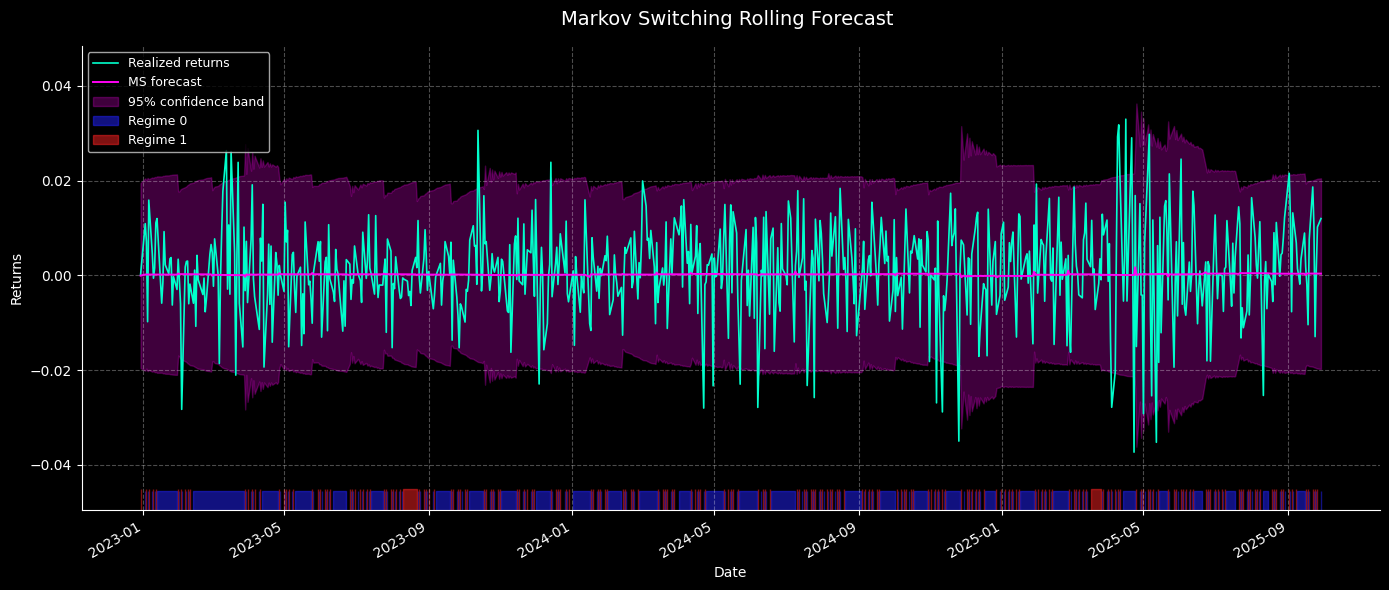

In [18]:
importlib.reload(utils)
mu, sigma = utils.forecast_arch_mean_sigma(res_garch_daily, 20)
z,_,_,_ = utils.forecast_markov_z(ms_res, 20)
utils.forecasts_garch_markov(mu, sigma, z)
df_ms = utils.rolling_markov_switching_forecast_ex5(
    daily_ret.squeeze(),
    start_oos="2022-12-30",
    end_oos=daily_ret.index[-1],
    h=20
)
utils.plot_markov_switching_forecast(df_ms)



The figure displays rolling 20-step-ahead forecasts obtained from the combined AR–GARCH–Markov specification, together with realized daily returns and 95% confidence bands.

The point forecasts fluctuate around zero and remain close to the conditional mean implied by the AR–GARCH filter, which is coherent with the earlier finding that daily returns exhibit weak mean dynamics. In practice, most of the forecasting content comes from the conditional dispersion (via GARCH) and from the regime-dependent distribution of standardized shocks (via the Markov component), rather than from predictable directional movements in the mean.

The confidence bands widen and shrink over time, reflecting time-variation in the forecasted conditional volatility. Periods where the bands become markedly wider coincide with episodes where large absolute returns cluster in the realized series, indicating that the model captures volatility clustering and adapts forecast uncertainty to market conditions.

The regime indicators should be interpreted with care. First, regime labels are arbitrary, so we identify the calm and turbulent regimes using the estimated shock variances (here, the low-variance state is regime 0 with $\sigma_0^2 \approx 0.24$, and the high-variance state is regime 1 with $\sigma_1^2 \approx 1.66$). Second, because we report regimes from *ex-ante* forecast probabilities (not an ex-post classification of realized volatility) and because the standardized residuals are already filtered by AR–GARCH, regime probabilities can be less persistent and may switch frequently. This behavior is consistent with the estimated transition probabilities and reflects uncertainty about the latent state rather than a modeling error.

Overall, the rolling forecasts are coherent with the in-sample results: the model does not aim to predict large return directions, but instead adjusts the width of the predictive distribution in response to changing volatility and regime risk. This confirms that the AR–GARCH–Markov framework is primarily useful for forecasting **risk** (time-varying uncertainty and latent volatility states) rather than point returns, which is consistent with standard empirical properties of financial return series.


## Monthly Returns

In [19]:
importlib.reload(utils)
res_garch_monthly = utils.fit_garch_ex5(
    monthly_ret.loc[:END_TRAINING],
    mean_model="AR",
    ar_lag=1 ,
    p=1,
    q=1
)
print(res_garch_monthly.summary())
utils.interpret_garch_ex5_results(res_garch_monthly)

                           AR - GARCH Model Results                           
Dep. Variable:                   GC=F   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                 -0.029
Vol Model:                      GARCH   Log-Likelihood:               -98.2654
Distribution:                  Normal   AIC:                           206.531
Method:            Maximum Likelihood   BIC:                           214.307
                                        No. Observations:                   35
Date:                Mon, Dec 29 2025   Df Residuals:                       33
Time:                        20:46:28   Df Model:                            2
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          0.3431      0.690      0.497      0.619 [ -1.010,  1.69

<u> Interpretation </u>
## ##### Monthly returns (AR–GARCH filter → Markov switching)

We fit an AR–GARCH filter to monthly returns (selected model: AR(1)–GARCH(1,1)) before applying Markov switching to the standardized shocks. Because the monthly sample is small ($T=35$), inference is less precise than for daily data.

Mean equation (filter):
$$
r_t = \mu + \phi r_{t-1} + \varepsilon_t.
$$
The AR(1) coefficient is not significant (p-value $\approx 0.763$), and the intercept is also not significant (p-value $\approx 0.619$), indicating weak mean predictability at the monthly frequency.

Volatility equation:
$$
h_t=\omega+\alpha_1\varepsilon_{t-1}^2+\beta_1 h_{t-1}.
$$
Estimates imply $\alpha_1 \approx 0$ and $\beta_1 \approx 0.9918$, so volatility persistence is
$$
\alpha_1+\beta_1 \approx 0.9918,
$$
which is extremely close to 1 (highly persistent / near-integrated volatility).


After filtering, we define
$$
z_t=\frac{\varepsilon_t}{\sigma_t},\qquad \sigma_t^2=h_t,
$$
and fit a two-regime Markov switching model (MarkovRegression):
$$
z_t\mid S_t=j \sim \mathcal N(c_j,\sigma_j^2),\qquad
\Pr(S_t=j\mid S_{t-1}=i)=p_{ij}.
$$
This allows standardized shocks to alternate between a low-variance (calm) and high-variance (turbulent) regime, complementing the smooth GARCH volatility dynamics.


In [20]:
importlib.reload(utils)
resid = utils.extract_z_from_arch(res_garch_monthly)
ms_res = utils.fit_markov_switching_model(
    resid,
    k_regimes=2,
    order=1,              
    trend="c",
    switching_variance=True

)

<u> Interpretation </u>


We fit a two-regime MarkovRegression model to the standardized residuals $z_t$ from the AR–GARCH filter:
$$
z_t \mid S_t=j \sim \mathcal N(c_j,\sigma_j^2),\qquad S_t\in\{0,1\}.
$$

The regimes are mainly differentiated by volatility. Regime 0 has a **low variance** ($\sigma_0^2 \approx 0.025$) while regime 1 has a **high variance** ($\sigma_1^2 \approx 1.137$), so we interpret regime 0 as **calm** and regime 1 as **turbulent**. The calm-regime mean is strongly significant and negative ($c_0 \approx -0.759$, p-value $\approx 0.000$), whereas the turbulent-regime mean is not significant ($c_1 \approx 0.178$, p-value $\approx 0.38$). For volatility, the turbulent variance is clearly significant (p-value $\approx 0.000$), while the calm variance is only weakly significant (p-value $\approx 0.094$), which is consistent with the small monthly sample ($T=35$).

For regime persistence, the estimated transition probability
$$
p_{00}\approx 0.80
$$
is highly significant (p-value $\approx 0.000$), implying that the calm regime is persistent. By contrast, $p_{10}\approx 0.04$ is not statistically significant (p-value $\approx 0.335$), so switching out of the turbulent regime is more uncertain in this small sample.


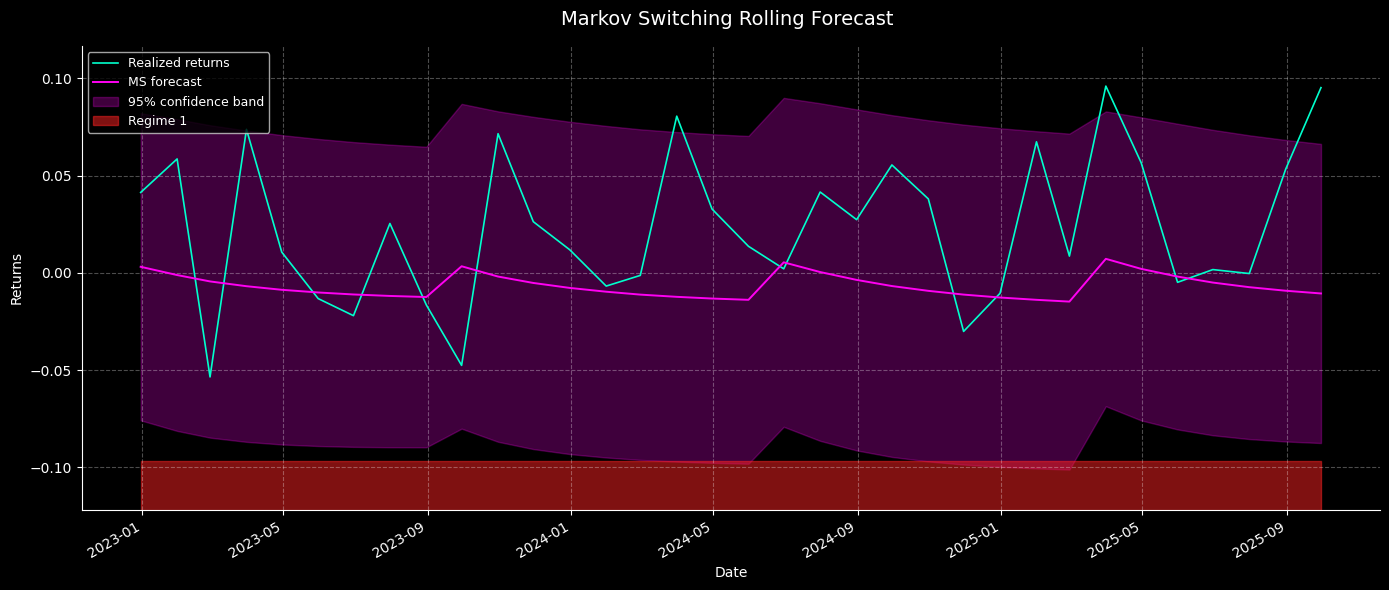

In [21]:
importlib.reload(utils)


df_ms = utils.rolling_markov_switching_forecast_ex5(
    monthly_ret.squeeze(),
    start_oos="2022-12-31",
    end_oos=monthly_ret.index[-1],
    h=9, p_arc=1, q_arch=1
)
utils.plot_markov_switching_forecast(df_ms)

<u> Interpretation </u>

In this monthly rolling forecast plot (with horizon $h=9$), the regime indicator is essentially constant: the chart displays only one regime throughout the out-of-sample period. So empirically, the Markov component is *not* producing meaningful regime alternation in the rolling exercise.

This is coherent with the monthly setting: the sample is very small ($T=35$) and, after AR–GARCH filtering, the standardized residual series is short and noisy. In that situation the MarkovRegression fit can easily collapse to a near-degenerate classification where one regime dominates the filtered (and therefore the forecast) regime probabilities almost everywhere. In other words, the model can still estimate two regimes in-sample, but in rolling forecasting the probability mass concentrates on a single state, so the argmax regime label never changes.

The confidence band remains wide and varies smoothly, which is consistent with the monthly GARCH(1,1) estimate being highly persistent ($\alpha+\beta \approx 0.99$). The plot therefore suggests that the forecasting behavior is driven mainly by the GARCH volatility forecast (persistent risk level), while the Markov regime layer adds little time variation in this out-of-sample monthly exercise.

Conclusion: for monthly data, the combined AR–GARCH–Markov specification behaves mostly like an AR–GARCH forecasting model, because the regime-switching signal is too weak (or too uncertain) to generate visible switching in the rolling forecasts.


## Quarterly

In [22]:
importlib.reload(utils)
res_garch_quarterly = utils.fit_garch_ex5(
    quarterly_ret.loc[:END_TRAINING],
    mean_model="AR",
    ar_lag=1 ,
    p=1,
    q=1
)
print(res_garch_quarterly.summary())
utils.interpret_garch_ex5_results(res_garch_quarterly)

                           AR - GARCH Model Results                           
Dep. Variable:                   GC=F   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                 -0.108
Vol Model:                      GARCH   Log-Likelihood:               -37.0063
Distribution:                  Normal   AIC:                           84.0126
Method:            Maximum Likelihood   BIC:                           86.0021
                                        No. Observations:                   11
Date:                Mon, Dec 29 2025   Df Residuals:                        9
Time:                        20:46:28   Df Model:                            2
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          1.2005      2.208      0.544      0.587 [ -3.127,  5.52

<u> Interpretation </u>

We first fit an AR(1)–GARCH(1,1) filter to quarterly returns (very small sample: $T=11$). The mean parameters are not statistically significant (Const p-value $\approx 0.587$, AR(1) p-value $\approx 0.865$), so there is no clear evidence of predictable mean dynamics at the quarterly frequency in this sample.

For volatility, the GARCH(1,1) parameters are also not statistically significant (omega p-value $\approx 0.474$, alpha p-value $\approx 1.000$, beta p-value $\approx 0.550$). With only 11 observations, this lack of significance is not surprising: GARCH estimation becomes extremely noisy at such low frequency / short sample sizes. In this context, the AR–GARCH step should be viewed mainly as a *filtering device* to produce standardized shocks rather than a precisely estimated volatility model.


In [23]:
importlib.reload(utils)
resid = utils.extract_z_from_arch(res_garch_quarterly)
ms_res = utils.fit_markov_switching_model(
    resid,
    k_regimes=2,
    order=1,              
    trend="c",
    switching_variance=True

)

<u> Interpretation </u>

We fit a two-regime MarkovRegression model to the standardized residuals $z_t$ from the AR–GARCH filter:
$$
z_t \mid S_t=j \sim \mathcal N(c_j,\sigma_j^2),\qquad S_t\in\{0,1\}.
$$

The estimated regimes differ mainly through volatility. Regime 0 has a very small variance estimate ($\sigma_0^2 \approx 0.002$), but it is not statistically significant (p-value $\approx 0.238$). Regime 1 has a much larger variance ($\sigma_1^2 \approx 1.323$) and it is statistically significant (p-value $\approx 0.044$), supporting the existence of a high-volatility (turbulent) shock state even in the quarterly data. For the means, the regime-0 intercept is significant ($c_0 \approx 0.427$, p-value $\approx 0.000$), while the regime-1 intercept is not ($c_1 \approx -0.145$, p-value $\approx 0.720$).

Given the extremely small sample ($T=11$), transition probabilities and regime classification should be interpreted cautiously: regime separation is driven mostly by the variance difference, and uncertainty about switching behavior is expected to be high.


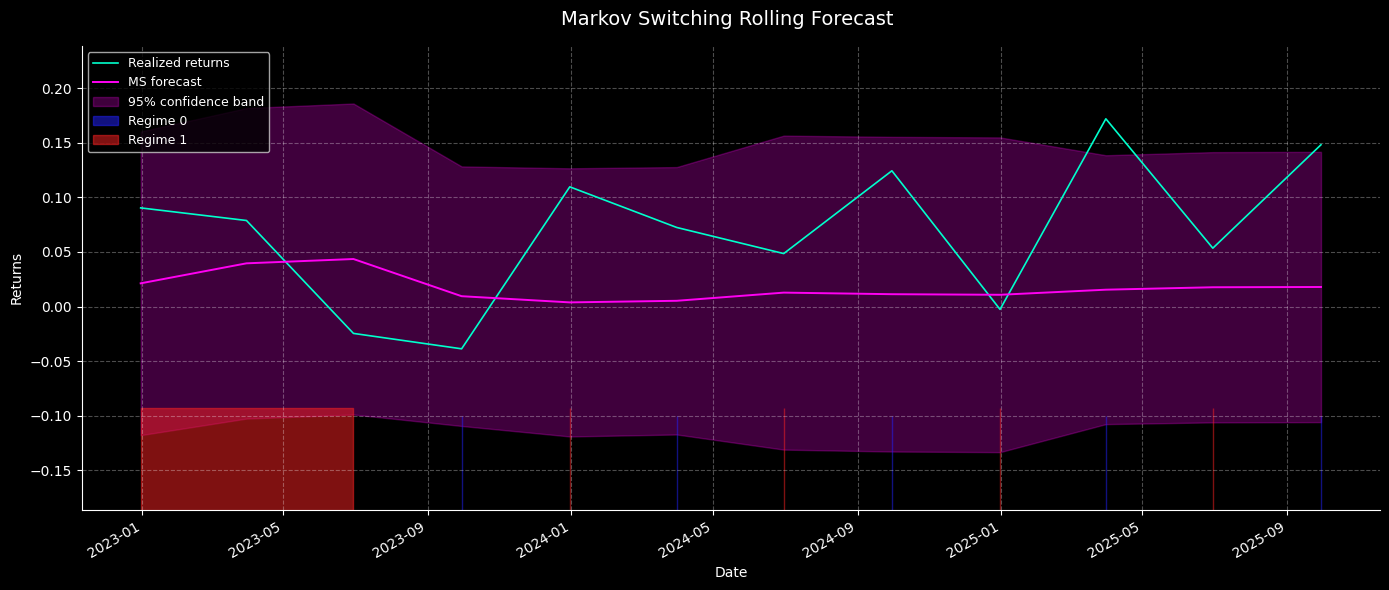

In [24]:
importlib.reload(utils)

df_ms = utils.rolling_markov_switching_forecast_ex5(
    quarterly_ret.squeeze(),
    start_oos="2022-12-31",
    end_oos=quarterly_ret.index[-1],
    h=3, p_arc=1, q_arch=1
)
utils.plot_markov_switching_forecast(df_ms)

<u> Interpretation </u>

The figure shows rolling $h=3$-step-ahead forecasts from the combined AR–GARCH–Markov model, along with realized quarterly returns and 95% confidence bands. The point forecasts remain smooth and relatively close to zero, which is consistent with the weak (non-significant) AR mean dynamics estimated at the quarterly frequency.

The plot displays **both regimes**, but the regime bars (especially the blue regime) appear **thin and sporadic**. This is expected with quarterly data: there are very few out-of-sample timestamps, so regime shading is only drawn at a small number of discrete dates, and the rolling procedure re-fits the model repeatedly on a tiny expanding sample. As a result, regime classification can look visually “patchy” even when two regimes exist in-sample.

Overall, what we can conclude from the quarterly forecast plot is limited by sample size: the combined model mainly provides a time-varying measure of forecast uncertainty (via the confidence band), while regime information is present but fragile. In this setting, seeing sparse regime changes and thin regime bars is normal and reflects data scarcity rather than a clear, stable switching pattern.
